# 5.2 Ключевые метрики роста продукта

#### Импорт библиотек

In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.errors import SettingWithCopyWarning

import os
import warnings
from pprint import pprint
import calendar

#### Глобальные настройки

In [402]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

#### Просмотр данных

In [403]:
def get_info_df(data, info_df={}):

    info_df['0. Размер DataFrame'] = data.shape
    info_df['1. Индексы DataFrame'] = data.index
    info_df['2. Колонки DataFrame'] = list(data.columns.values)
    info_df['3. Числовые колонки'] = dict(data.select_dtypes(include=[int, float, complex]).dtypes)
    info_df['4. Строковые колонки'] = dict(data.select_dtypes(include=[object]).dtypes)
    info_df['5. Колонки с пропусками'] = list(data.columns[data.isnull().any()])
    # info_df['6. Строки с пропусками'] = list(data[data.isnull().any(axis=1)].index.values)
    info_df['7. Колличество строк без пропусков'] = len(data.value_counts())
    info_df['8. Колличество полных дубликатов'] = len(data[data.duplicated(keep=False)])
    info_df['9. Колличество занимаемой памяти'] = f"{round(data.memory_usage(deep=True).sum() / 1048576, 2)} мегабайт"

    display(data.head())
    return info_df

df = pd.read_csv('../datasets/data.csv')

pprint(get_info_df(df), width=400, compact=True)

,Дата,ID сессии,ID клиента,Доход,Оценка
0,2021-01-05,eeehjltlceclayhacecerhyyxhrxs,45870310,0.0,NaN
1,2021-01-06,eeehrcecacecerlrhacecerygejeb,76545402,0.0,NaN
2,2021-01-06,eeehalhalhjaracecerxhrhtrm,424242,0.0,NaN
3,2021-01-06,eeehrcecacecerlrhacecerygejeb,76545402,0.0,NaN
4,2021-01-06,eeehalhalhjaracecerxhrhtrm,424242,0.0,NaN


{'0. Размер DataFrame': (19010, 5),
 '1. Индексы DataFrame': RangeIndex(start=0, stop=19010, step=1),
 '2. Колонки DataFrame': ['Дата', 'ID сессии', 'ID клиента', 'Доход', 'Оценка'],
 '3. Числовые колонки': {'ID клиента': dtype('int64'), 'Доход': dtype('float64'), 'Оценка': dtype('float64')},
 '4. Строковые колонки': {'ID сессии': dtype('O'), 'Дата': dtype('O')},
 '5. Колонки с пропусками': ['Оценка'],
 '7. Колличество строк без пропусков': 3999,
 '8. Колличество полных дубликатов': 5170,
 '9. Колличество занимаемой памяти': '3.21 мегабайт'}


#### Предварительная обработка данных

In [404]:
df = df.drop_duplicates()

df['Дата'] = pd.to_datetime(df['Дата'])

name_month = list(calendar.month_name)[1:]

df['year'] = df['Дата'].dt.year
df['month'] = df['Дата'].dt.month
df['week'] = df['Дата'].dt.isocalendar().week
df['day'] = df['Дата'].dt.day
df['month_name'] = df['month'].apply(lambda x: name_month[x-1])


display(df.head())

,Дата,ID сессии,ID клиента,Доход,Оценка,year,month,week,day,month_name
0,2021-01-05,eeehjltlceclayhacecerhyyxhrxs,45870310,0.0,NaN,2021,1,1,5,January
1,2021-01-06,eeehrcecacecerlrhacecerygejeb,76545402,0.0,NaN,2021,1,1,6,January
2,2021-01-06,eeehalhalhjaracecerxhrhtrm,424242,0.0,NaN,2021,1,1,6,January
5,2021-01-07,eeehrjetgcecalacecerrlknyve,702421,0.0,NaN,2021,1,1,7,January
7,2021-01-08,eeehlheajrjlcecacecertkyasrbr,2515442,0.0,NaN,2021,1,1,8,January


#### <u>Расчет метрик</u>
- Количество сессий
- MAU
- WAU (среднее)
- DAU (среднее)
- Липкость 
- Конверсию в продажу
- ARPU
- ARPPU
- Удовлетворенность клиентов

In [405]:
def get_metrics(group):
    count_sessions = group['ID сессии'].nunique()
    mau = group['ID клиента'].nunique()
    wau = group.groupby('week')['ID клиента'].nunique().mean()
    dau = group.groupby('day')['ID клиента'].nunique().mean()
    stickiness = dau / mau if mau > 0 else 0
    conversion_rate = group[group['Доход'] > 0]['ID сессии'].nunique() / count_sessions if count_sessions > 0 else 0
    arpu = group['Доход'].sum() / mau if mau > 0 else 0
    arppu = group['Доход'].sum() / group[group['Доход'] > 0]['ID клиента'].nunique() if group[group['Доход'] > 0]['ID клиента'].nunique() > 0 else 0
    avg_rating = group['Оценка'].mean()

    return pd.Series({
        'Колличество сессий': count_sessions,
        'MAU': mau,
        'WAU': wau,
        'DAU': dau,
        'Липкость': stickiness,
        'Конверсия в продажу': conversion_rate,
        'ARPU': arpu,
        'ARPPU': arppu,
        'Средняя оценка': avg_rating
    })

#### <u>Для каждого месяца</u>

In [406]:
df.groupby('month_name').apply(get_metrics).reset_index()

,month_name,Колличество сессий,MAU,WAU,DAU,Липкость,Конверсия в продажу,ARPU,ARPPU,Средняя оценка
0,February,8912.0,7546.0,2018.5,297.892857,0.039477,0.138577,3605.693413,22864.338233,4.004937
1,January,2823.0,2495.0,647.0,102.769231,0.041190,0.472193,10262.154625,20272.427387,4.000655
2,March,4086.0,3610.0,742.6,137.178571,0.038000,0.224425,4987.514249,20298.676932,4.022770


#### <u>Для каждой недели</u>

In [407]:
df.groupby('week').apply(get_metrics).reset_index()

,week,Колличество сессий,MAU,WAU,DAU,Липкость,Конверсия в продажу,ARPU,ARPPU,Средняя оценка
0,1,9.0,8.0,8.0,1.500000,0.187500,0.000000,0.000000,0.000000,NaN
1,2,806.0,741.0,741.0,108.571429,0.146520,0.414392,6949.528533,15557.705870,3.961749
2,3,1104.0,1010.0,1010.0,150.142857,0.148656,0.480978,10408.162918,20333.161600,4.003289
3,4,904.0,829.0,829.0,142.000000,0.171291,0.517699,11993.040530,21947.528916,4.023508
4,5,2364.0,2146.0,2146.0,316.714286,0.147584,0.509306,12434.092198,22963.478361,4.004329
5,6,2228.0,2026.0,2026.0,299.000000,0.147581,0.002244,43.378376,17576.917931,4.000000
6,7,2255.0,2031.0,2031.0,299.714286,0.147570,0.006652,114.809116,15545.154371,3.812500
7,8,2066.0,1871.0,1871.0,276.142857,0.147591,0.005324,108.999859,18539.885101,4.363636
8,9,2495.0,2269.0,2269.0,336.285714,0.148209,0.042084,920.224182,20470.477151,4.067227
9,10,1554.0,1413.0,1413.0,207.571429,0.146901,0.521879,11256.357712,20209.953553,4.017131


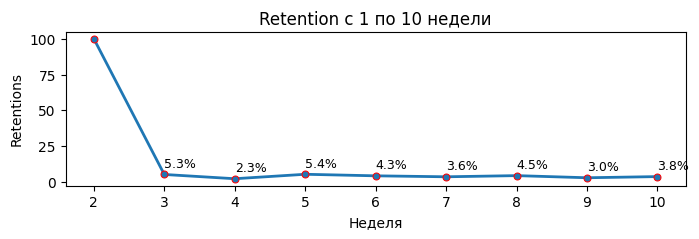

In [408]:
retentions = []

for i in range(2, 11):
    users_in_2 = df[df['week'] == 2]['ID клиента'].unique()
    users_in_week = df[df['week'] == i]['ID клиента'].unique()
    retained_users = len(set(users_in_2) & set(users_in_week))
    retention_rate = retained_users / len(users_in_2) * 100
    retentions.append({'week': i, 'retention_rate': retention_rate})

result = pd.DataFrame(retentions)

f, ax = plt.subplots(figsize=(8, 2))

sns.lineplot(x=result['week'],
             y=result['retention_rate'],
             marker='o',
             linewidth=2,
             markersize=5,
             markeredgecolor='red')

for i in range(1, len(result)):
    plt.annotate(f"{round(result['retention_rate'][i], 1)}%",
                 (result['week'][i], result['retention_rate'][i]),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='left',
                 fontsize=9,
                 color='black')

plt.title("Retention с 1 по 10 недели")
plt.xlabel('Неделя')
plt.ylabel('Retentions')


plt.show()